In [2]:
# 1. import library yang akan digunakan dalam proses
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import requests
from io import StringIO
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\snsv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\snsv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\snsv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
# 2. Load Data ( data yang dihasilkan dari scraping koemntar postingan)
file_path = 'komentar.csv'
data = pd.read_csv(file_path)
data.dropna(subset=['Komentar'], inplace=True)

In [5]:
# 3. Pra-premrosesan data
stop_words = set(stopwords.words('indonesian'))
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [6]:
# Kamus slang
slang_dict = {
    'gk': 'tidak', 'ga': 'tidak', 'ngga': 'tidak', 'nggak': 'tidak', 'tdk': 'tidak',
    'bgt': 'banget', 'bgtu': 'begitu', 'bkin': 'bikin', 'tp': 'tapi', 'dr': 'dari',
    'dgn': 'dengan', 'jg': 'juga', 'bbrp': 'beberapa', 'sy': 'saya', 'sm': 'sama',
    'dlm': 'dalam', 'aja': 'saja', 'krn': 'karena'
}

# Tambahkan kamus tidak baku dari file Excel
kamus_df = pd.read_excel('kamuskatabaku.xlsx')
kamus_slang = dict(zip(kamus_df['tidak_baku'].astype(str), kamus_df['kata_baku'].astype(str)))
slang_dict.update(kamus_slang)

# Load daftar kata baku KBBI
kbbi_url = 'https://raw.githubusercontent.com/damzaky/kbbi-wordlist/main/kbbi.txt'
kbbi_words = set(requests.get(kbbi_url).text.lower().splitlines())

#penamabahan kamus diharapkan bisa mendapatkan lebih banyak kamus sehingga kata-kata yang terserap ada didalam rumus
all_tokens = ' '.join(data['Komentar'].astype(str)).lower().split()
suspected_slangs = set(word for word in all_tokens if word not in kbbi_words and word not in slang_dict)
print("Contoh kata yang diduga slang dan belum ditangani:", list(suspected_slangs)[:20])

Contoh kata yang diduga slang dan belum ditangani: ['anggota', 'pur.', 'disimpan', 'egi', 'kota', 'sendiri,,,ini', 'berkesan', 'dipertanggungjawabkan', 'ngezoom', 'semoga', 'semesti', 'umkm', 'berkunjung,', 'rojdiun', 'bidang,', 'sibolga', 'lum', 'respectueux', 'renungannya', 'gajadi']


In [7]:
# Fungsi preprocessing

def cleaningText(text):
    text = re.sub(r"@[A-Za-z0-9_]+", "", text) #menghapus mention
    text = re.sub(r"#[A-Za-z0-9_]+", "", text) #menghapus hastag
    text = re.sub(r"RT", "", text) #menghapus RT
    text = re.sub(r"https?://\S+", "", text) #menghapus link
    text = re.sub(r"\d+", "", text) #menghapus angka 
    text = re.sub(r"[^a-zA-Z\s]", "", text) #menghapus tanda baca
    text = re.sub(r"\n", " ", text) #menghapus karakter baru
    return text.strip()

def casefoldingText(text):
    return text.lower()

def tokenizingText(text):
    return word_tokenize(text)

def filteringText(words):
    return [word for word in words if word not in stop_words]

def stemmingText(words):
    return [stemmer.stem(word) for word in words] # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata

def toSentence(words):
    return ' '.join(words)

def replace_slang(text):
    return ' '.join([slang_dict.get(word, word) for word in text.split()])

def preprocess_text(text):
    text = cleaningText(text)
    text = casefoldingText(text)
    text = replace_slang(text)
    words = tokenizingText(text)
    words = filteringText(words)
    words = stemmingText(words)
    return toSentence(words)

# Terapkan preprocessing (Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir')
data['cleaned'] = data['Komentar'].astype(str).apply(preprocess_text)

In [8]:
# 4. Load Kamus Positif & Negatif dari URL
url_pos = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv'
url_neg = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv'

positive_df = pd.read_csv(url_pos)
negative_df = pd.read_csv(url_neg)

positive = positive_df.iloc[:, 0].astype(str).tolist() + [
    'hebat', 'terbaik', 'bagus', 'suka', 'mantap', 'kerennn', 'luar biasa', 'top', 'oke', 'yes', 'asik', 'amazing', 'recommended'
]

negative = negative_df.iloc[:, 0].astype(str).tolist() + [
    'jelek', 'buruk', 'parah', 'mengecewakan', 'nggak enak', 'gagal', 'payah', 'busuk', 'ga jelas', 'sampah', 'benci', 'menjengkelkan', 'ngaco', 'negatif', 'negatif sendiri', 'bohong', 'penipu', 'tidak puas', 'basi', 'boikot'
]

neutral = ['informasi', 'berita', 'update', 'pengumuman', 'jadwal']

In [9]:
# 5. Labeling Sentimen

def label_sentiment(text):
    tokens = text.split()
    pos_count = sum(1 for word in tokens if word in positive)
    neg_count = sum(1 for word in tokens if word in negative)
    neu_count = sum(1 for word in tokens if word in neutral)

    if pos_count > max(neg_count, neu_count):
        return 2
    elif neg_count > max(pos_count, neu_count):
        return 0
    return 1

data['label'] = data['cleaned'].apply(label_sentiment)

# Data Augmentation sederhana: duplikasi teks netral dan negatif
minority_classes = data[data['label'] != 2]  # Netral dan Negatif
augmented_data = pd.concat([data, minority_classes.copy(), minority_classes.copy()])

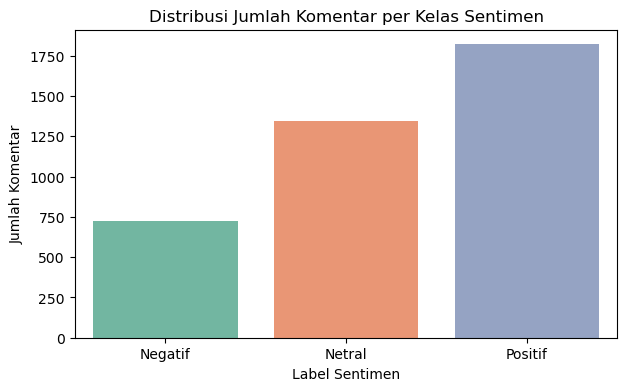

In [10]:
# Visualisasi distribusi label
label_counts = data['label'].value_counts().sort_index()
label_map = {0: 'Negatif', 1: 'Netral', 2: 'Positif'}
existing_labels = label_counts.index.tolist()
label_names = [label_map[label] for label in existing_labels]

plt.figure(figsize=(7, 4))
sns.barplot(x=label_names, y=label_counts.values, hue=label_names, palette='Set2', legend=False)
plt.title('Distribusi Jumlah Komentar per Kelas Sentimen')
plt.ylabel('Jumlah Komentar')
plt.xlabel('Label Sentimen')
plt.show()

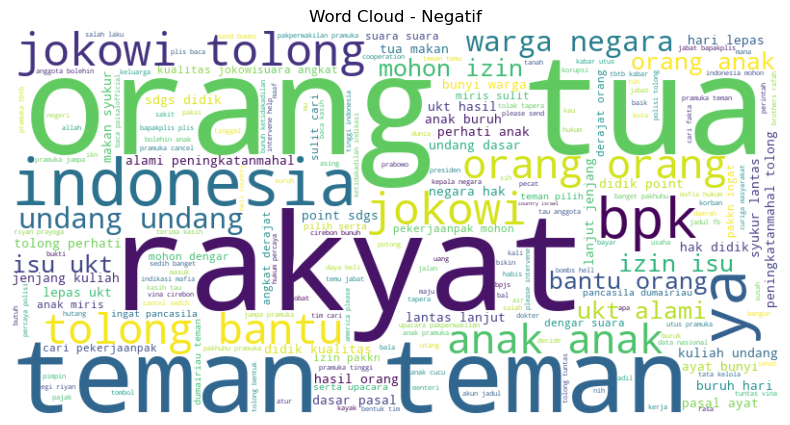

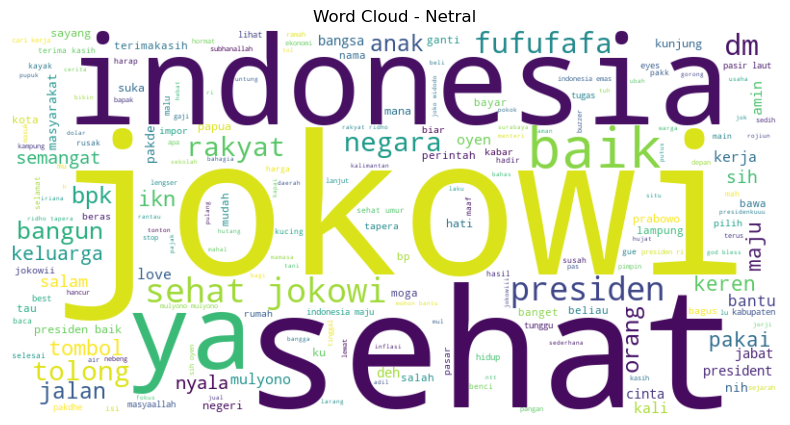

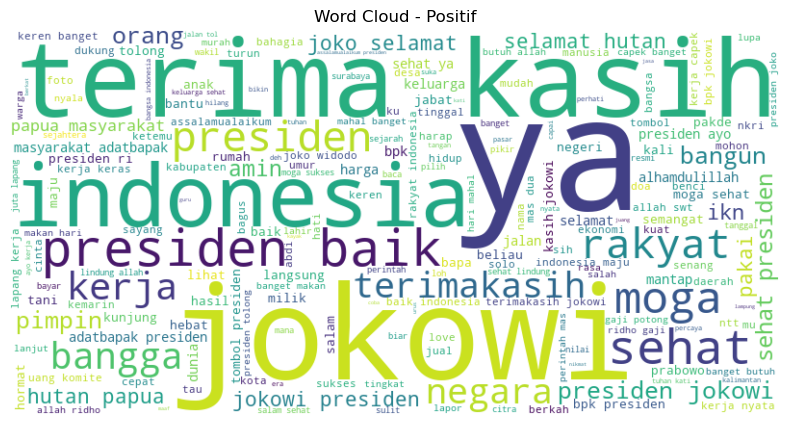

In [11]:
# 6. Word Cloud

def generate_wordcloud(label_value, label_name):
    text = ' '.join(data[data['label'] == label_value]['cleaned'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - {label_name}')
    plt.show()

generate_wordcloud(0, 'Negatif')
generate_wordcloud(1, 'Netral')
generate_wordcloud(2, 'Positif')

In [12]:
# 7. Ekstraksi Fitur TF-IDF
vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1,2))
X = vectorizer.fit_transform(augmented_data['cleaned']).toarray()
y = augmented_data['label']

In [13]:
# 8. Split Data dan SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [14]:
# 9. Training Model
models = {
    "Multinomial NB": MultinomialNB(),
    "LightGBM": LGBMClassifier(random_state=42),
    "MLP Classifier": MLPClassifier(random_state=42, max_iter=300),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

accuracies = {}
results = []


Model: Multinomial NB
Akurasi: 0.7801992528019925
              precision    recall  f1-score   support

     Negatif       0.68      0.80      0.73       435
      Netral       0.87      0.74      0.80       807
     Positif       0.76      0.86      0.80       364

    accuracy                           0.78      1606
   macro avg       0.77      0.80      0.78      1606
weighted avg       0.79      0.78      0.78      1606



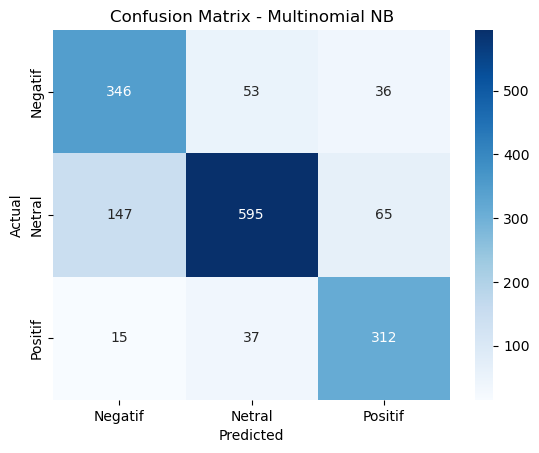

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15826
[LightGBM] [Info] Number of data points in the train set: 9684, number of used features: 1525
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612

Model: LightGBM
Akurasi: 0.8835616438356164
              precision    recall  f1-score   support

     Negatif       0.91      0.84      0.87       435
      Netral       0.87      0.92      0.90       807
     Positif       0.88      0.85      0.87       364

    accuracy                           0.88      1606
   macro avg       0.89      0.87      0.88      1606
weighted avg       0.88      0.88      0.88      1606



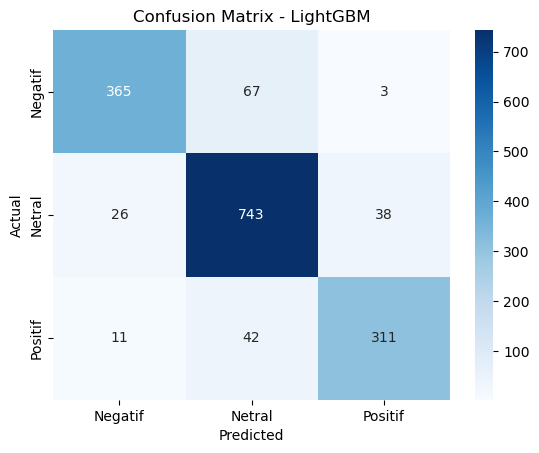


Model: MLP Classifier
Akurasi: 0.9582814445828145
              precision    recall  f1-score   support

     Negatif       0.94      0.97      0.95       435
      Netral       0.98      0.98      0.98       807
     Positif       0.94      0.90      0.92       364

    accuracy                           0.96      1606
   macro avg       0.95      0.95      0.95      1606
weighted avg       0.96      0.96      0.96      1606



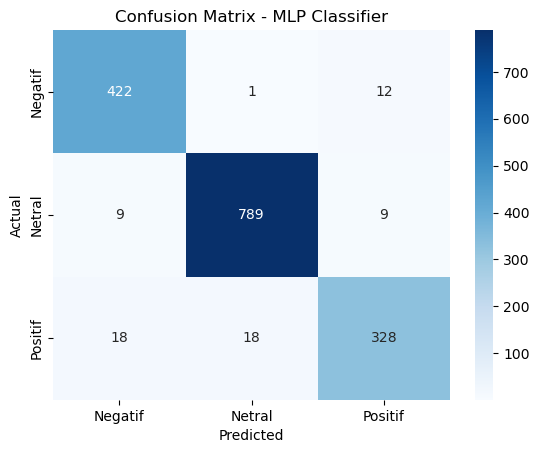


Model: CatBoost
Akurasi: 0.8655043586550436
              precision    recall  f1-score   support

     Negatif       0.89      0.85      0.87       435
      Netral       0.87      0.89      0.88       807
     Positif       0.83      0.83      0.83       364

    accuracy                           0.87      1606
   macro avg       0.86      0.86      0.86      1606
weighted avg       0.87      0.87      0.87      1606



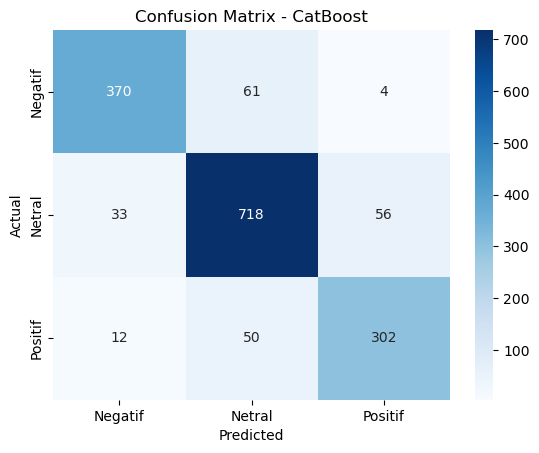

In [15]:
# 10. Evaluasi Semua Model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec_weighted = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    accuracies[name] = acc
    results.append([name, acc, prec_weighted, rec_weighted, f1_weighted])

    print(f"\nModel: {name}")
    print("Akurasi:", acc)
    print(classification_report(y_test, y_pred, target_names=['Negatif', 'Netral', 'Positif']))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Netral', 'Positif'], yticklabels=['Negatif', 'Netral', 'Positif'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

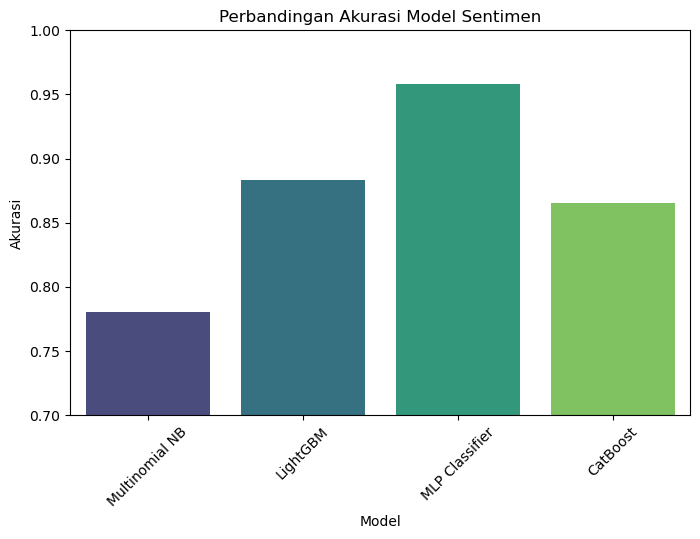

In [16]:
# 11. Visualisasi Akurasi
plt.figure(figsize=(8, 5))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), hue=list(accuracies.keys()), palette='viridis', legend=False)
plt.ylim(0.7, 1.0)
plt.title('Perbandingan Akurasi Model Sentimen')
plt.ylabel('Akurasi')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()

In [17]:
# 12. Komparasi Kinerja
comparison_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Weighted Precision", "Weighted Recall", "Weighted F1-Score"])
print("\nTabel Komparasi Model Baru:")
print(comparison_df)


Tabel Komparasi Model Baru:
            Model  Accuracy  Weighted Precision  Weighted Recall  \
0  Multinomial NB  0.780199            0.792175         0.780199   
1        LightGBM  0.883562            0.884385         0.883562   
2  MLP Classifier  0.958281            0.958258         0.958281   
3        CatBoost  0.865504            0.865782         0.865504   

   Weighted F1-Score  
0           0.781564  
1           0.883219  
2           0.958112  
3           0.865431  


In [25]:
# 13. Model Terbaik
best_model = max(accuracies, key=accuracies.get)
print(f"\nModel dengan akurasi terbaik: {best_model} ({accuracies[best_model]:.4f})")


Model dengan akurasi terbaik: MLP Classifier (0.9583)


## Analisis Hasil 

- MLP Classifier adalah model dengan akurasi tertinggi yaitu 0.9583 (95.83%).
- Tidak hanya akurasi, model ini juga memiliki Weighted Precision, Recall, dan F1-Score tertinggi dibanding model lain dengan nilai
  a. Weighted Precision : 0.958258
  b. Weighted Recall : 0.958281
  c. Weighted F1-Score : 0.958112

## Analisis Kinerja
- MLP Classifier mengungguli model lainnya secara konsisten di semua metrik.
- LightGBM dan CatBoost menunjukkan kinerja cukup baik, namun masih di bawah MLP.
- Multinomial Naive Bayes (NB) memiliki kinerja paling rendah, wajar karena ini model dasar (baseline) dan mungkin kurang cocok untuk dataset ini.